In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D,AveragePooling2D,AveragePooling3D
from keras.layers import Dense, GlobalAveragePooling3D,GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler,ReduceLROnPlateau
from keras.optimizers import SGD, RMSprop, Adadelta
from keras.utils import np_utils, generic_utils, Sequence
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional_recurrent import ConvLSTM2D
import keras

import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn import preprocessing

Using TensorFlow backend.


In [2]:
# image specification
img_cols,img_rows=100,176
nb_frames = 16    # img_depth or number of frames used for each video
# CNN Training parameters
nb_classes = 27
channels = 2

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# integer encode
labels = pd.read_csv('E:\Jupyter\Project\jester-v1-labels.csv',sep=';',header=None,names=['Class'])     # reading the csv file
label_encoder = LabelEncoder()
labels['Label'] = label_encoder.fit_transform(labels['Class'])

#train
train = pd.read_csv('E:\Jupyter\Project\jester-v1-train.csv',sep=';',header=None,names=['Video','Class'])     # reading the csv file
train['Label'] = label_encoder.fit_transform(train['Class'])

#validation
validation = pd.read_csv('E:\Jupyter\Project\jester-v1-validation.csv',sep=';',header=None,names=['Video','Class'])     # reading the csv file
validation['Label'] = label_encoder.fit_transform(validation['Class'])

#test
#test = pd.read_csv('E:\Jupyter\Project\jester-v1-test.csv',sep=';',header=None,names=['Video'])     # reading the csv file

#print labels
#labels
"""
partition_dict = {
    "train": train["Video"].tolist(),
    "validation": validation["Video"].tolist()
}"""
temp = pd.concat([train, validation])
temp = temp.set_index("Video")
#temp = train.set_index("Video")
temp.transpose()
labels_dict = temp["Label"].to_dict()

In [4]:
import random
def data_gen(train_list):
    while True:
        X_tr=[]
        label=[]
        for vid_ID in random.sample(train_list,64):
            frames = []
            frame_count=0
            pos_dir = os.path.join("E:/Jupyter/Project/generated_images512_timeSampled/pos",str(vid_ID))
            neg_dir = os.path.join("E:/Jupyter/Project/generated_images512_timeSampled/neg",str(vid_ID))
            for img_ID in sorted(os.listdir(pos_dir)):
                if frame_count < nb_frames:
                    pos = os.path.join(pos_dir,img_ID)
                    neg = os.path.join(neg_dir,img_ID)
                    p_img = cv2.imread(pos,0)
                    p_img = cv2.resize(p_img,(img_rows,img_cols),interpolation=cv2.INTER_AREA)
                    n_img = cv2.imread(neg,0)
                    n_img = cv2.resize(n_img,(img_rows,img_cols),interpolation=cv2.INTER_AREA)
                    frame = cv2.merge((p_img,n_img))
                    frames.append(frame)
                    frame_count+=1
                else:
                    break
            while frame_count < nb_frames:
                frames.append(np.zeros((img_cols,img_rows,channels), np.uint8))
                frame_count+=1
            input_img = np.array(frames)
            ipt=np.rollaxis(np.rollaxis(input_img,2,0),2,0)
            ipt=np.rollaxis(ipt,2,0)
            X_tr.append(ipt)
            label.append(labels_dict[vid_ID])

        X_tr_array = np.array(X_tr)   # convert the frames read into array

        Y_train = np_utils.to_categorical(label, nb_classes)

        yield X_tr_array,Y_train

In [5]:
print(next(data_gen(train["Video"].tolist()))[0].shape)

(64, 16, 100, 176, 2)


In [6]:
#low resolution network
weight_decay = 0.005
from keras import regularizers
model = Sequential()
model.add(MaxPooling3D(pool_size=(1, 2, 2),input_shape=(nb_frames,  img_cols, img_rows, channels)))

model.add(Conv3D(8,(1,5,5),activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv3D(8,(5,1,1),activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Conv3D(32,(1,5,5), activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv3D(32,(3,1,1), activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64,(1,3,5), activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv3D(64,(3,1,1), activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling3D(pool_size=(1, 1, 4 )))

model.add(Flatten())
model.add(Dense(512, activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dropout(0.5))

model.add(Dense(nb_classes,kernel_initializer='normal',kernel_regularizer=regularizers.l2(weight_decay)))

model.add(Activation('softmax'))

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling3d_1 (MaxPooling3 (None, 16, 50, 88, 2)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 16, 46, 84, 8)     408       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 12, 46, 84, 8)     328       
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 12, 23, 42, 8)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 12, 19, 38, 32)    6432      
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 10, 19, 38, 32)    3104      
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 5, 9, 19, 32)      0         
__________

In [16]:
import os
save_dir = os.path.join(os.getcwd(),'save_model')
print(os.getcwd())
model_name = "30%"
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(model_path, monitor = 'val_acc', 
                            save_best_only=True, verbose=1)
#earlystop
earlystop = EarlyStopping(monitor='val_loss', patience=50, verbose =1)

E:\Jupyter\Project


In [17]:
sgd = SGD(lr=0.003,  momentum=0.9, nesterov=False)
rms = RMSprop(decay=1e-6)
ada = Adadelta(lr=0.1,decay=1e-6)
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd,
              #optimizer=ada,
              #optimizer = Adam(lr=0.0001),
              metrics=['acc'])

In [23]:
nb_epoch = 380
#steps_per_epoch=int((len(X_val_new)*1.5)/batch_size)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.05, 
                               cooldown=0, patience=10, min_lr=0.005/(2^4),verbose=1)
hist = model.fit_generator(data_gen(train["Video"].tolist()[0:]),
                           validation_data=data_gen(validation["Video"].tolist()[0:1500]),
                           steps_per_epoch=64,
                           validation_steps=4,
                           epochs = nb_epoch,
                           callbacks=[checkpoint,lr_reducer]
                          )

Epoch 1/380
64/64 [==============================] - 98s 2s/step - loss: 4.4923 - acc: 0.1655 - val_loss: 4.3640 - val_acc: 0.1836

Epoch 00001: val_acc did not improve from 0.23047
Epoch 2/380
64/64 [==============================] - 97s 2s/step - loss: 4.4395 - acc: 0.1697 - val_loss: 4.3267 - val_acc: 0.2539

Epoch 00002: val_acc improved from 0.23047 to 0.25391, saving model to E:\Jupyter\Project\save_model\3DCNN+3LSTM_64_6_jester
Epoch 3/380
64/64 [==============================] - 99s 2s/step - loss: 4.4288 - acc: 0.1692 - val_loss: 4.3091 - val_acc: 0.2031

Epoch 00003: val_acc did not improve from 0.25391
Epoch 4/380
64/64 [==============================] - 101s 2s/step - loss: 4.4519 - acc: 0.1577 - val_loss: 4.2895 - val_acc: 0.2344

Epoch 00004: val_acc did not improve from 0.25391
Epoch 5/380
64/64 [==============================] - 101s 2s/step - loss: 4.3711 - acc: 0.1809 - val_loss: 4.3199 - val_acc: 0.2109

Epoch 00005: val_acc did not improve from 0.25391
Epoch 6/380
6


Epoch 00044: val_acc did not improve from 0.27734
Epoch 45/380
64/64 [==============================] - 97s 2s/step - loss: 3.7013 - acc: 0.2148 - val_loss: 3.7053 - val_acc: 0.2617

Epoch 00045: val_acc did not improve from 0.27734
Epoch 46/380
64/64 [==============================] - 100s 2s/step - loss: 3.6984 - acc: 0.2285 - val_loss: 3.6275 - val_acc: 0.2266

Epoch 00046: val_acc did not improve from 0.27734
Epoch 47/380
64/64 [==============================] - 98s 2s/step - loss: 3.6787 - acc: 0.2224 - val_loss: 3.7001 - val_acc: 0.2031

Epoch 00047: val_acc did not improve from 0.27734
Epoch 48/380
64/64 [==============================] - 97s 2s/step - loss: 3.6641 - acc: 0.2314 - val_loss: 3.7392 - val_acc: 0.2109

Epoch 00048: val_acc did not improve from 0.27734
Epoch 49/380
64/64 [==============================] - 97s 2s/step - loss: 3.6818 - acc: 0.2180 - val_loss: 3.5697 - val_acc: 0.2305

Epoch 00049: val_acc did not improve from 0.27734
Epoch 50/380
64/64 [=============

64/64 [==============================] - 96s 1s/step - loss: 3.3052 - acc: 0.2449 - val_loss: 3.2611 - val_acc: 0.2539

Epoch 00088: val_acc did not improve from 0.29688
Epoch 89/380
64/64 [==============================] - 96s 2s/step - loss: 3.2803 - acc: 0.2578 - val_loss: 3.2805 - val_acc: 0.2461

Epoch 00089: val_acc did not improve from 0.29688
Epoch 90/380
64/64 [==============================] - 99s 2s/step - loss: 3.2876 - acc: 0.2476 - val_loss: 3.1542 - val_acc: 0.2734

Epoch 00090: val_acc did not improve from 0.29688
Epoch 91/380
64/64 [==============================] - 97s 2s/step - loss: 3.2453 - acc: 0.2568 - val_loss: 3.2780 - val_acc: 0.2656

Epoch 00091: val_acc did not improve from 0.29688
Epoch 92/380
64/64 [==============================] - 99s 2s/step - loss: 3.2725 - acc: 0.2456 - val_loss: 3.4028 - val_acc: 0.2227

Epoch 00092: val_acc did not improve from 0.29688
Epoch 93/380
64/64 [==============================] - 99s 2s/step - loss: 3.2490 - acc: 0.2544 - v

64/64 [==============================] - 99s 2s/step - loss: 2.8813 - acc: 0.2913 - val_loss: 2.9955 - val_acc: 0.3125

Epoch 00174: val_acc did not improve from 0.36328
Epoch 175/380
64/64 [==============================] - 100s 2s/step - loss: 2.8797 - acc: 0.2974 - val_loss: 2.9390 - val_acc: 0.3242

Epoch 00175: val_acc did not improve from 0.36328
Epoch 176/380
64/64 [==============================] - 98s 2s/step - loss: 2.8806 - acc: 0.2920 - val_loss: 2.9963 - val_acc: 0.2812

Epoch 00176: val_acc did not improve from 0.36328
Epoch 177/380
64/64 [==============================] - 95s 1s/step - loss: 2.8627 - acc: 0.3040 - val_loss: 2.8923 - val_acc: 0.3242

Epoch 00177: val_acc did not improve from 0.36328
Epoch 178/380
64/64 [==============================] - 96s 1s/step - loss: 2.8883 - acc: 0.2886 - val_loss: 2.8474 - val_acc: 0.3164

Epoch 00178: val_acc did not improve from 0.36328
Epoch 179/380
64/64 [==============================] - 98s 2s/step - loss: 2.8656 - acc: 0.29

64/64 [==============================] - 99s 2s/step - loss: 2.7872 - acc: 0.3159 - val_loss: 2.9161 - val_acc: 0.2773

Epoch 00217: val_acc did not improve from 0.36719
Epoch 218/380
64/64 [==============================] - 99s 2s/step - loss: 2.7972 - acc: 0.3003 - val_loss: 2.8211 - val_acc: 0.3008

Epoch 00218: val_acc did not improve from 0.36719
Epoch 219/380
64/64 [==============================] - 97s 2s/step - loss: 2.7870 - acc: 0.3145 - val_loss: 2.7423 - val_acc: 0.3594

Epoch 00219: val_acc did not improve from 0.36719
Epoch 220/380
64/64 [==============================] - 98s 2s/step - loss: 2.8309 - acc: 0.3013 - val_loss: 2.9703 - val_acc: 0.3086

Epoch 00220: val_acc did not improve from 0.36719
Epoch 221/380
64/64 [==============================] - 99s 2s/step - loss: 2.7842 - acc: 0.3071 - val_loss: 2.8478 - val_acc: 0.3320

Epoch 00221: val_acc did not improve from 0.36719
Epoch 222/380
64/64 [==============================] - 99s 2s/step - loss: 2.8248 - acc: 0.304

64/64 [==============================] - 98s 2s/step - loss: 2.7306 - acc: 0.3242 - val_loss: 2.8457 - val_acc: 0.3320

Epoch 00260: val_acc did not improve from 0.36719
Epoch 261/380
64/64 [==============================] - 98s 2s/step - loss: 2.7133 - acc: 0.3313 - val_loss: 2.9548 - val_acc: 0.3164

Epoch 00261: val_acc did not improve from 0.36719
Epoch 262/380
64/64 [==============================] - 98s 2s/step - loss: 2.7142 - acc: 0.3323 - val_loss: 2.7975 - val_acc: 0.2891

Epoch 00262: val_acc did not improve from 0.36719
Epoch 263/380
64/64 [==============================] - 99s 2s/step - loss: 2.7296 - acc: 0.3274 - val_loss: 2.9663 - val_acc: 0.3164

Epoch 00263: val_acc did not improve from 0.36719
Epoch 264/380
64/64 [==============================] - 98s 2s/step - loss: 2.7349 - acc: 0.3354 - val_loss: 2.8347 - val_acc: 0.2852

Epoch 00264: val_acc did not improve from 0.36719
Epoch 265/380
64/64 [==============================] - 97s 2s/step - loss: 2.7417 - acc: 0.328

64/64 [==============================] - 97s 2s/step - loss: 2.7318 - acc: 0.3289 - val_loss: 2.9916 - val_acc: 0.3125

Epoch 00303: val_acc did not improve from 0.37891
Epoch 304/380
64/64 [==============================] - 98s 2s/step - loss: 2.7081 - acc: 0.3438 - val_loss: 2.7142 - val_acc: 0.3398

Epoch 00304: val_acc did not improve from 0.37891
Epoch 305/380
64/64 [==============================] - 98s 2s/step - loss: 2.7103 - acc: 0.3357 - val_loss: 2.8828 - val_acc: 0.3164

Epoch 00305: val_acc did not improve from 0.37891

Epoch 00305: ReduceLROnPlateau reducing learning rate to 0.0008333333333333334.
Epoch 306/380
64/64 [==============================] - 98s 2s/step - loss: 2.7244 - acc: 0.3350 - val_loss: 2.8746 - val_acc: 0.3281

Epoch 00306: val_acc did not improve from 0.37891
Epoch 307/380
64/64 [==============================] - 98s 2s/step - loss: 2.7040 - acc: 0.3347 - val_loss: 2.9191 - val_acc: 0.3203

Epoch 00307: val_acc did not improve from 0.37891
Epoch 308/380

In [24]:
hist1 = model.fit_generator(data_gen(train["Video"].tolist()[0:]),
                           validation_data=data_gen(validation["Video"].tolist()[0:1500]),
                           steps_per_epoch=64,
                           validation_steps=4,
                           epochs = nb_epoch,
                           callbacks=[checkpoint,lr_reducer]
                          )

Epoch 1/380
64/64 [==============================] - 101s 2s/step - loss: 2.6919 - acc: 0.3633 - val_loss: 2.9183 - val_acc: 0.2695

Epoch 00001: val_acc did not improve from 0.39062
Epoch 2/380
64/64 [==============================] - 99s 2s/step - loss: 2.6267 - acc: 0.3801 - val_loss: 2.8362 - val_acc: 0.3555

Epoch 00002: val_acc did not improve from 0.39062
Epoch 3/380
64/64 [==============================] - 100s 2s/step - loss: 2.6886 - acc: 0.3589 - val_loss: 2.9011 - val_acc: 0.3555

Epoch 00003: val_acc did not improve from 0.39062
Epoch 4/380
64/64 [==============================] - 102s 2s/step - loss: 2.7086 - acc: 0.3633 - val_loss: 2.9822 - val_acc: 0.3398

Epoch 00004: val_acc did not improve from 0.39062
Epoch 5/380
64/64 [==============================] - 100s 2s/step - loss: 2.6181 - acc: 0.3875 - val_loss: 2.8889 - val_acc: 0.3008

Epoch 00005: val_acc did not improve from 0.39062
Epoch 6/380
64/64 [==============================] - 102s 2s/step - loss: 2.6998 - acc

64/64 [==============================] - 100s 2s/step - loss: 2.6893 - acc: 0.3835 - val_loss: 2.9629 - val_acc: 0.2969

Epoch 00045: val_acc did not improve from 0.39062
Epoch 46/380
64/64 [==============================] - 102s 2s/step - loss: 2.6558 - acc: 0.3777 - val_loss: 2.8491 - val_acc: 0.3398

Epoch 00046: val_acc did not improve from 0.39062
Epoch 47/380
64/64 [==============================] - 100s 2s/step - loss: 2.6851 - acc: 0.3767 - val_loss: 3.0444 - val_acc: 0.3047

Epoch 00047: val_acc did not improve from 0.39062
Epoch 48/380
64/64 [==============================] - 99s 2s/step - loss: 2.6459 - acc: 0.4006 - val_loss: 2.9981 - val_acc: 0.3242

Epoch 00048: val_acc did not improve from 0.39062
Epoch 49/380
64/64 [==============================] - 98s 2s/step - loss: 2.6677 - acc: 0.3906 - val_loss: 3.1143 - val_acc: 0.2812

Epoch 00049: val_acc did not improve from 0.39062
Epoch 50/380
64/64 [==============================] - 97s 2s/step - loss: 2.7144 - acc: 0.3711 

64/64 [==============================] - 98s 2s/step - loss: 2.7124 - acc: 0.3916 - val_loss: 3.1873 - val_acc: 0.2852

Epoch 00088: val_acc did not improve from 0.39062
Epoch 89/380
64/64 [==============================] - 99s 2s/step - loss: 2.6748 - acc: 0.3909 - val_loss: 2.8742 - val_acc: 0.3750

Epoch 00089: val_acc did not improve from 0.39062
Epoch 90/380
64/64 [==============================] - 98s 2s/step - loss: 2.6775 - acc: 0.3896 - val_loss: 2.9434 - val_acc: 0.3438

Epoch 00090: val_acc did not improve from 0.39062
Epoch 91/380
64/64 [==============================] - 99s 2s/step - loss: 2.6690 - acc: 0.3911 - val_loss: 3.1391 - val_acc: 0.2969

Epoch 00091: val_acc did not improve from 0.39062

Epoch 00091: ReduceLROnPlateau reducing learning rate to 0.0008333333333333334.
Epoch 92/380
64/64 [==============================] - 100s 2s/step - loss: 2.6279 - acc: 0.4041 - val_loss: 3.0884 - val_acc: 0.3164

Epoch 00092: val_acc did not improve from 0.39062
Epoch 93/380
64/

64/64 [==============================] - 98s 2s/step - loss: 2.7045 - acc: 0.3840 - val_loss: 2.8463 - val_acc: 0.3906

Epoch 00131: val_acc did not improve from 0.39062

Epoch 00131: ReduceLROnPlateau reducing learning rate to 0.0008333333333333334.
Epoch 132/380
64/64 [==============================] - 94s 1s/step - loss: 2.6979 - acc: 0.3909 - val_loss: 3.0846 - val_acc: 0.3203

Epoch 00132: val_acc did not improve from 0.39062
Epoch 133/380
64/64 [==============================] - 100s 2s/step - loss: 2.6794 - acc: 0.4033 - val_loss: 3.0409 - val_acc: 0.3047

Epoch 00133: val_acc did not improve from 0.39062
Epoch 134/380
64/64 [==============================] - 101s 2s/step - loss: 2.6966 - acc: 0.4031 - val_loss: 3.0201 - val_acc: 0.3359

Epoch 00134: val_acc did not improve from 0.39062
Epoch 135/380
64/64 [==============================] - 95s 1s/step - loss: 2.6970 - acc: 0.4006 - val_loss: 3.0931 - val_acc: 0.3203

Epoch 00135: val_acc did not improve from 0.39062
Epoch 136/3

64/64 [==============================] - 97s 2s/step - loss: 2.6906 - acc: 0.4155 - val_loss: 3.3902 - val_acc: 0.2734

Epoch 00216: val_acc did not improve from 0.39062
Epoch 217/380
64/64 [==============================] - 102s 2s/step - loss: 2.6996 - acc: 0.4150 - val_loss: 3.1969 - val_acc: 0.3008

Epoch 00217: val_acc did not improve from 0.39062
Epoch 218/380
64/64 [==============================] - 100s 2s/step - loss: 2.6542 - acc: 0.4314 - val_loss: 3.1623 - val_acc: 0.3438

Epoch 00218: val_acc did not improve from 0.39062
Epoch 219/380
64/64 [==============================] - 99s 2s/step - loss: 2.6788 - acc: 0.4241 - val_loss: 3.0647 - val_acc: 0.3164

Epoch 00219: val_acc did not improve from 0.39062
Epoch 220/380
64/64 [==============================] - 101s 2s/step - loss: 2.6884 - acc: 0.4182 - val_loss: 3.0014 - val_acc: 0.3359

Epoch 00220: val_acc did not improve from 0.39062
Epoch 221/380
64/64 [==============================] - 101s 2s/step - loss: 2.6950 - acc: 0

64/64 [==============================] - 100s 2s/step - loss: 2.6674 - acc: 0.4429 - val_loss: 3.3276 - val_acc: 0.2812

Epoch 00259: val_acc did not improve from 0.39062
Epoch 260/380
64/64 [==============================] - 101s 2s/step - loss: 2.6803 - acc: 0.4275 - val_loss: 3.3275 - val_acc: 0.3086

Epoch 00260: val_acc did not improve from 0.39062
Epoch 261/380
64/64 [==============================] - 98s 2s/step - loss: 2.6984 - acc: 0.4250 - val_loss: 3.3515 - val_acc: 0.3125

Epoch 00261: val_acc did not improve from 0.39062

Epoch 00261: ReduceLROnPlateau reducing learning rate to 0.0008333333333333334.
Epoch 262/380
64/64 [==============================] - 101s 2s/step - loss: 2.6966 - acc: 0.4282 - val_loss: 3.1722 - val_acc: 0.3594

Epoch 00262: val_acc did not improve from 0.39062
Epoch 263/380
64/64 [==============================] - 98s 2s/step - loss: 2.7598 - acc: 0.4167 - val_loss: 3.1739 - val_acc: 0.2852

Epoch 00263: val_acc did not improve from 0.39062
Epoch 264/

64/64 [==============================] - 99s 2s/step - loss: 2.7013 - acc: 0.4419 - val_loss: 3.2104 - val_acc: 0.3047

Epoch 00302: val_acc did not improve from 0.39062
Epoch 303/380
64/64 [==============================] - 98s 2s/step - loss: 2.6752 - acc: 0.4573 - val_loss: 3.3631 - val_acc: 0.2578

Epoch 00303: val_acc did not improve from 0.39062
Epoch 304/380
64/64 [==============================] - 98s 2s/step - loss: 2.6884 - acc: 0.4260 - val_loss: 3.2519 - val_acc: 0.3398

Epoch 00304: val_acc did not improve from 0.39062
Epoch 305/380
64/64 [==============================] - 99s 2s/step - loss: 2.6798 - acc: 0.4424 - val_loss: 3.3778 - val_acc: 0.2734

Epoch 00305: val_acc did not improve from 0.39062
Epoch 306/380
64/64 [==============================] - 100s 2s/step - loss: 2.6854 - acc: 0.4282 - val_loss: 3.0745 - val_acc: 0.3281

Epoch 00306: val_acc did not improve from 0.39062
Epoch 307/380
64/64 [==============================] - 102s 2s/step - loss: 2.7071 - acc: 0.4

64/64 [==============================] - 99s 2s/step - loss: 2.7182 - acc: 0.4358 - val_loss: 3.2749 - val_acc: 0.3086

Epoch 00345: val_acc did not improve from 0.39062
Epoch 346/380
64/64 [==============================] - 98s 2s/step - loss: 2.6967 - acc: 0.4404 - val_loss: 3.1563 - val_acc: 0.3125

Epoch 00346: val_acc did not improve from 0.39062
Epoch 347/380
64/64 [==============================] - 97s 2s/step - loss: 2.6696 - acc: 0.4463 - val_loss: 3.1220 - val_acc: 0.3203

Epoch 00347: val_acc did not improve from 0.39062
Epoch 348/380
64/64 [==============================] - 97s 2s/step - loss: 2.7243 - acc: 0.4355 - val_loss: 3.3723 - val_acc: 0.2891

Epoch 00348: val_acc did not improve from 0.39062
Epoch 349/380
64/64 [==============================] - 99s 2s/step - loss: 2.6750 - acc: 0.4570 - val_loss: 3.1767 - val_acc: 0.3477

Epoch 00349: val_acc did not improve from 0.39062
Epoch 350/380
64/64 [==============================] - 98s 2s/step - loss: 2.6983 - acc: 0.445

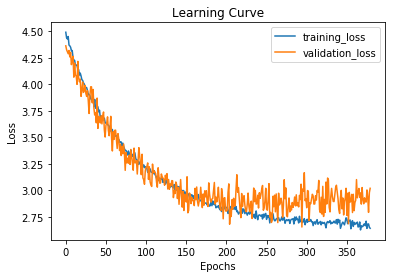

In [25]:
training_loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

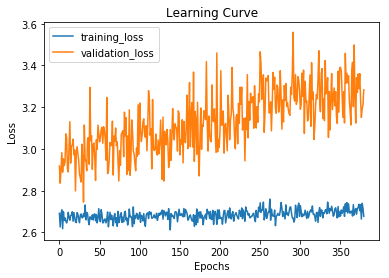

In [36]:
training_loss = hist1.history['loss']
val_loss = hist1.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

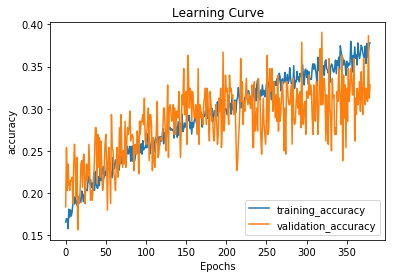

In [26]:
training_acc = hist.history['acc']
val_acc = hist.history['val_acc']

plt.plot(training_acc, label="training_accuracy")
plt.plot(val_acc, label="validation_accuracy")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [ ]:
from keras.models import Model, load_model
model1_name = "deep"
model1_path = os.path.join(save_dir, model1_name)
model1 = load_model(model1_path)


In [38]:
# Training data

X_tr=[]           # variable to store entire dataset
label=[]

from tqdm import tqdm

ls_path = os.path.join("E:/Jupyter/Project/generated_images512_timeSampled")

for vid_ID in tqdm(validation["Video"].tolist()[0:2000]):
    frames = []
    frame_count=0
    pos_dir = os.path.join(os.path.join(ls_path,"pos"),str(vid_ID))
    neg_dir = os.path.join(os.path.join(ls_path,"pos"),str(vid_ID))
    for img_ID in sorted(os.listdir(pos_dir)):
        if frame_count < nb_frames:
            pos = os.path.join(pos_dir,img_ID)
            neg = os.path.join(neg_dir,img_ID)
            p_img = cv2.imread(pos,0)
            p_img = cv2.resize(p_img,(img_rows,img_cols),interpolation=cv2.INTER_AREA)
            n_img = cv2.imread(neg,0)
            n_img = cv2.resize(n_img,(img_rows,img_cols),interpolation=cv2.INTER_AREA)
            frame = cv2.merge((p_img,n_img))
            frames.append(frame)
            frame_count+=1
        else:
            break
    while frame_count < nb_frames:
        frames.append(np.zeros((img_cols,img_rows,channels), np.uint8))
        frame_count+=1
    input_img = np.array(frames)
    ipt=np.rollaxis(np.rollaxis(input_img,2,0),2,0)
    ipt=np.rollaxis(ipt,2,0)
    X_tr.append(ipt)
    label.append(labels_dict[vid_ID])

print (ipt.shape)
num_samples = len(X_tr) 
print (num_samples)
X_tr_array = np.array(X_tr)   # convert the frames read into array

train_data = [X_tr_array,label]
(X_train, y_train) = (train_data[0],train_data[1])
train_set = np.zeros((num_samples, nb_frames, img_cols,img_rows,2))
for h in range(num_samples):
    train_set[h][:][:][:][:]=X_train[h,:,:,:]
Y_train = np_utils.to_categorical(y_train, nb_classes)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:42<00:00, 47.50it/s]


(16, 100, 176, 2)
2000


In [ ]:
test_pred =model1.predict(train_set[50:70])
result = np.argmax(test_pred, axis =1)
print(result)

In [ ]:
img_array = train_set[50]
from sklearn.metrics import confusion_matrix
met = confusion_matrix(np.argmax(Y_train,axis =1), np.argmax(model1.predict(train_set),axis =1))
print(met)

In [64]:
import itertools
def confusion_matrix_plot(cm, classes, 
                          title='Normalized Confusion Matrix', 
                          normalize=True, 
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    plt.subplots(1, 1, figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, range(27), rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

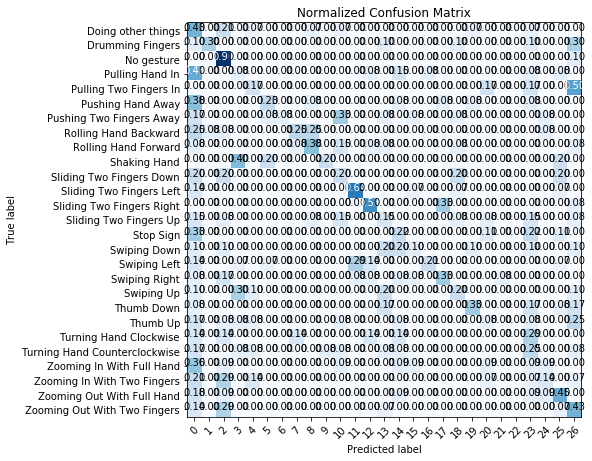

In [65]:
confusion_matrix_plot(met, classes=labels.sort_values(by=['Label'])['Class'].tolist())

In [66]:
labels.sort_values(by=['Label'])

,Class,Label
26,Doing other things,0
24,Drumming Fingers,1
25,No gesture,2
5,Pulling Hand In,3
11,Pulling Two Fingers In,4
4,Pushing Hand Away,5
10,Pushing Two Fingers Away,6
13,Rolling Hand Backward,7
12,Rolling Hand Forward,8
22,Shaking Hand,9


In [46]:
model1.evaluate(train_set,Y_train)

2000/2000 [==============================] - ETA: 20 - ETA: 15 - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 12s 6ms/step


[3.2207009716033936, 0.234]